In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from citableclass import Citable
from corpussearch import search
import ephem

# Load data

n200  = number of iterations steps  
th10  = allowed std err for linear regression   
sig0.2 = observer deviation from start point  
start0.5 = observer start point  

In [2]:
cite1 = Citable("values_n200_th10_sig0.2_start0.5.json", formats="local", project="kreisgrabenanlage")
cite2 = Citable("values_n500_th15_sig0.2_start0.5.json", formats="local", project="kreisgrabenanlage")
cite3 = Citable("values_n1500_th10_sig0.3_start0.5.json", formats="local", project="kreisgrabenanlage")
cite4 = Citable("values_n2500_th5_sig0.4_start0.5.json", formats="local", project="kreisgrabenanlage")
#######!!!    nur cite 5 und cite 6 hat die Azimuthe von T. Michel    !!!########
####### aber reicht ja, sind j eh immer die selben ########
cite5 = Citable("values_n550_th15_sig0.2_start0.5.json", formats="local", project="kreisgrabenanlage")
cite6 = Citable("values_n550_th55_sig0.2_start0.5.json", formats="local", project="kreisgrabenanlage")
df = cite5.digitalresource()
df.head()

,gate,object,latitude,longitude,azimuth,prob (az),bins (az),mean azimuth,sigma azimuth,declination,prob (dec),bins (dec),mean declination,sigma declination,number elements,azimuth(michel)
0,1,QuedlinburgI,51.813308,11.178354,"[318.5567, 318.466, 301.67631, 330.67859, 311....","[0.0015117788000000001, 0.0027730629, 0.004810...","[301.22092, 302.909169, 304.597418, 306.285667...",320.423137,7.147553,"[27.60859, 27.56668, 18.94393, 32.61713, 24.08...","[0.0015926656, 0.0031116714, 0.0057481814, 0.0...","[18.69019, 19.4592955, 20.228401, 20.9975065, ...",28.268624,3.249270,5,"[[134, 136], [21, 23], [214, 217], [312, 313]]"
1,2,QuedlinburgI,51.813308,11.178354,"[357.99142, 351.97775, 321.03162, 358.42307, 3...","[5.2436e-06, 1.67168e-05, 4.92572e-05, 0.00013...","[313.39173, 315.721499, 318.051268, 320.381037...",348.852293,8.301546,"[38.15901, 37.747, 28.72893, 38.16963, 37.9682...","[0.0, 2e-10, 2.3e-09, 2.11e-08, 1.695e-07, 1.1...","[25.13234, 25.7850575, 26.437775, 27.0904925, ...",36.909942,1.724592,1,"[[134, 136], [21, 23], [214, 217], [312, 313]]"
2,3,QuedlinburgI,51.813308,11.178354,"[39.74462, 34.41164, 14.3832, 20.67756, 17.453...","[0.0048290551, 0.0078198874, 0.011896451300000...","[11.24346, 13.7487415, 16.254023, 18.7593045, ...",31.833283,10.025190,"[28.38247, 30.6662, 36.78745, 35.33817, 36.140...","[0.0001141817, 0.00029401570000000003, 0.00070...","[17.24282, 18.2470195, 19.251219, 20.2554185, ...",31.221370,3.782583,2,"[[134, 136], [21, 23], [214, 217], [312, 313]]"
3,5,QuedlinburgI,51.813308,11.178354,"[188.82668, 215.66022, 222.96723, 202.34319, 2...","[0.004886123, 0.007579714800000001, 0.01096853...","[180.08317, 184.365925, 188.64868, 192.931435,...",209.273072,16.242891,"[-37.65491, -30.15238, -26.89667, -34.87665, -...","[0.0354914898, 0.0465834335, 0.0563111278, 0.0...","[-38.18664, -36.4089685, -34.631297, -32.85362...",-31.424014,6.196391,1,"[[134, 136], [21, 23], [214, 217], [312, 313]]"
4,6,QuedlinburgI,51.813308,11.178354,"[284.53739, 295.55975, 279.70906, 279.29026, 3...","[0.0157409835, 0.022881678500000002, 0.0296101...","[270.00451, 273.875465, 277.74642, 281.617375,...",284.391778,11.351395,"[8.92735, 15.47006, 5.98458, 5.72788, 26.05564...","[0.0253207186, 0.0354082901, 0.0456947111, 0.0...","[0.0027900000000000004, 1.8583129999999999, 3....",8.680300,6.548552,1,"[[134, 136], [21, 23], [214, 217], [312, 313]]"


### make subset from Michels data

In [3]:
az_michel=list()
for i in range(len(df["azimuth(michel)"])):
    for j in range(len(df["azimuth(michel)"][i])):
        az_michel.append(np.mean(df["azimuth(michel)"][i][j]))
data=np.array(list(set(az_michel)))

### Anmerkung!!:  
- die unterschiedliche Anzahl macht Sinn, da bei Michel alle 90 Gates vorkommen, bei der linearen Regression nur 53  
- bei der linearen Regression hängt es davon ab wie groß die Threshold ist 

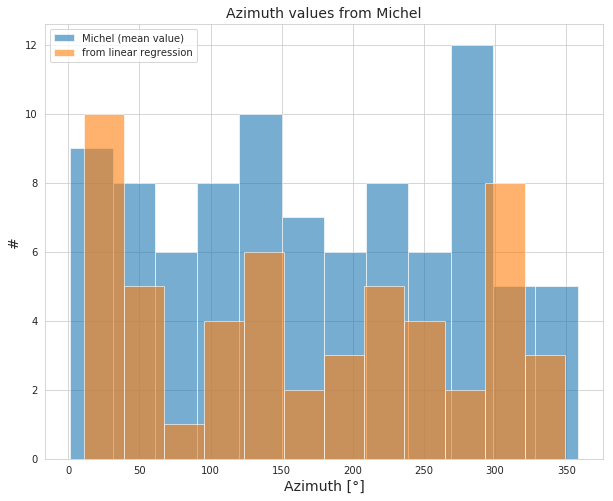

In [4]:
plt.figure(figsize=(10,8))
plt.hist(data, bins=12, alpha=.6, density=False, label="Michel (mean value)")
plt.hist(np.array(df["mean azimuth"]), bins=12, alpha=.6, density=False, label="from linear regression")
plt.title('Azimuth values from Michel', fontsize=14);
plt.xlabel("Azimuth [°]", fontsize=14);
plt.ylabel("#", fontsize=14);
plt.legend()

## Auxiliary functions

In [5]:
# auxiliary to simplify normal distributions for n data points
def ndi(mu,sd,n):
    b=np.random.normal(mu,sd,n)
    return(b)

# Simulation
## Generation of mixed distribution

## Parameter

In [6]:
# no of gates, gaussian distribution of directions
n_gates= 4
# mean values
#value:  -30.361514640687762 var 9.488898890923112
#value:  37.18086067610277 var 14.458853132679794
#value:  12.767138961255649 var 4.543496345526992
#value:  -8.563945763567334 var 5.7156606842991975
#value:  -37.42626719012814 var 8.738291591935992

mu=(-37,-30,-8,12,37,45,26,19)
# std. variation
sd=1
# additional noise
noise_bmg = 0.5
# number of simulated directions
n=250

### Mixed distribution of simulated data points

In [7]:
# mixed distribution from simulation
a = [ndi(mu[i],sd,n) for i in range(n_gates)]
bmg=np.concatenate(a)
# simulated data for mixed distribution
data = np.random.normal(bmg, noise_bmg)[:, np.newaxis]

/mnt/ResearchCloud/Projects/kreisgrabenanlage/.kernel/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


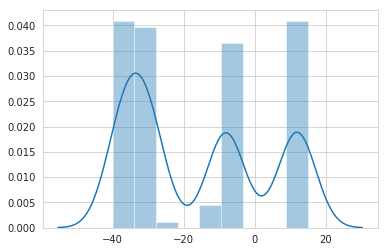

In [8]:
sns.distplot(data);

In [9]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='spherical').fit(data) for n in n_components]

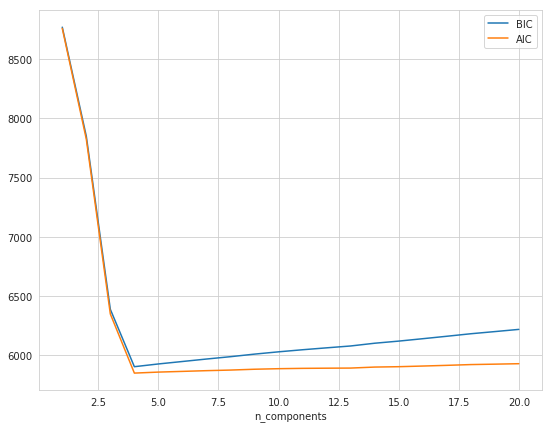

In [10]:
plt.figure(figsize=(9,7))
plt.plot(n_components, [m.bic(data) for m in models], label='BIC')
plt.plot(n_components, [m.aic(data) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

# Site data

In [11]:
# minimal number of defining features pro gates
number=0
# upper bound for sigma
sigma=4
# minimum declination
mdec=-50
# max azimuth
maxaz=380
# list of empirical deviations sd from selected gates
sel_df=df[["mean declination","sigma declination"]][(df["mean azimuth"] < maxaz) & (df["mean declination"] > mdec) & (df["number elements"] > number) & (df["sigma declination"]< sigma)]
sel_df.head()

,mean declination,sigma declination
0,28.268624,3.249270
1,36.909942,1.724592
2,31.221370,3.782583
5,31.516133,3.569968
6,-30.497132,3.281430


In [12]:
l1=sel_df["mean declination"].tolist()
l2=sel_df["sigma declination"].tolist()
print(len(l1),len(l2))

21 21


In [13]:
# mixed distribution from simulation
b = tuple([ndi(l1[i],l2[i],n) for i in range(len(l1))])
bmg=np.concatenate(b)
# simulated data for mixed distribution
data = np.random.normal(bmg, noise_bmg)[:, np.newaxis]

(array([0.01100543, 0.02622571, 0.01328847, 0.00720036, 0.01302505,
        0.00831261, 0.00143422, 0.00011708, 0.00450754, 0.00272209,
        0.00380507, 0.01563005, 0.03137719, 0.01501539]),
 array([-45.0396826 , -38.53207364, -32.02446468, -25.51685572,
        -19.00924676, -12.5016378 ,  -5.99402884,   0.51358012,
          7.02118909,  13.52879805,  20.03640701,  26.54401597,
         33.05162493,  39.55923389,  46.06684285]),
 <a list of 14 Patch objects>)

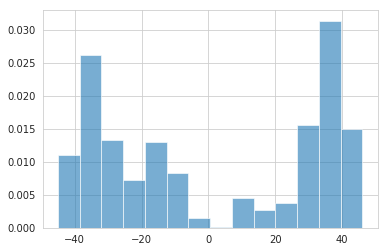

In [14]:
plt.hist(data, bins='auto', alpha=.6, density=True)

/mnt/ResearchCloud/Projects/kreisgrabenanlage/.kernel/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


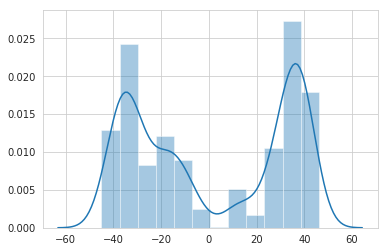

In [15]:
sns.distplot(data);

value:  -15.125202593340232 var 31.75237487071465
value:  35.749523942873 var 21.444233717168917
value:  15.115178018550152 var 26.71844827893148
value:  -34.94099233908241 var 18.228341214432366


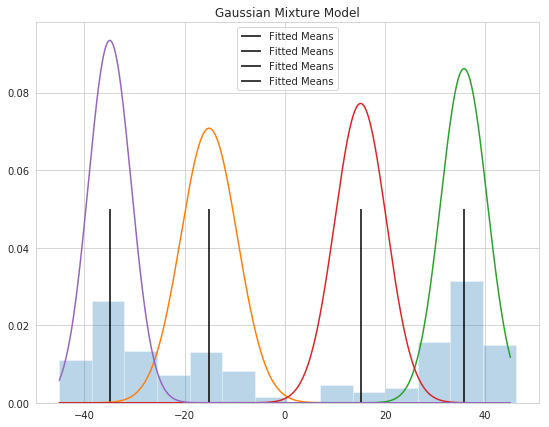

In [16]:
gmm = GaussianMixture(n_gates,covariance_type='spherical')
gmm.fit(data)
x = np.linspace(-45, 45, 3 * 2500 + 1)
plt.figure(figsize=(9,7))
plt.hist(data, bins='auto', alpha=.3, density=True, log=False)

for i in np.arange(n_gates):
    mu=gmm.means_[i,0]
    var=gmm.covariances_[i]
    print("value: ", mu,"var",var)
    plt.vlines(mu, ymin=0, ymax=0.05, label='Fitted Means')
    plt.plot(x, norm.pdf(x, mu, np.sqrt(var)))
    plt.legend()
    plt.title('Gaussian Mixture Model')

### Anzahl der Gaussians entnommen aus AIC/BIC 

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice. As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works as a density estimator, not how well it works as a clustering algorithm. I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

In [17]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='spherical').fit(data) for n in n_components]

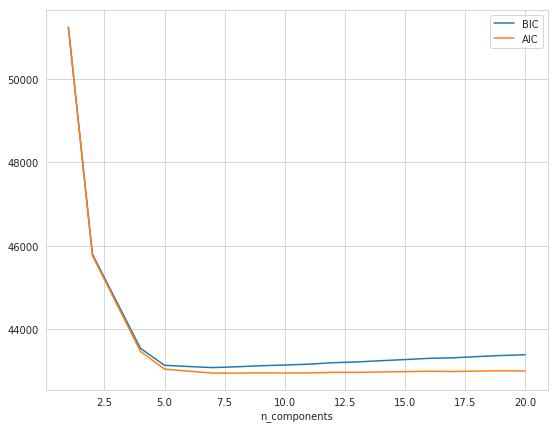

In [18]:
plt.figure(figsize=(9,7))
plt.plot(n_components, [m.bic(data) for m in models], label='BIC')
plt.plot(n_components, [m.aic(data) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

value:  35.911383631918746 var 20.215870054255337
value:  -30.54387040972321 var 10.116074055572769
value:  -14.834095557473212 var 29.111175163522095
value:  16.385167771618175 var 38.60031771494272
value:  -37.176753288615835 var 8.572731875748902


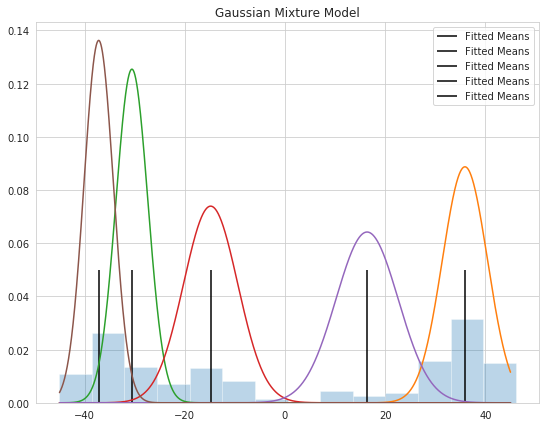

In [19]:
# best n gates according to BIC
n_gates=5
gmm = GaussianMixture(n_gates,covariance_type='spherical')
gmm.fit(data)
x = np.linspace(-45, 45, 3 * 2500 + 1)
plt.figure(figsize=(9,7))
plt.hist(data, bins='auto', alpha=.3, density=True, log=False)

for i in np.arange(n_gates):
    mu=gmm.means_[i,0]
    var=gmm.covariances_[i]
    print("value: ", mu,"var",var)
    plt.vlines(mu, ymin=0, ymax=0.05, label='Fitted Means')
    plt.plot(x, norm.pdf(x, mu, np.sqrt(var)))
    plt.legend()
    plt.title('Gaussian Mixture Model')

# 1d GMM Modeling Literature

https://km3pipe.readthedocs.io/en/latest/auto_examples/stats/plot_fitting_dists.html

B.W. Silverman, “Density Estimation for Statistics and Data Analysis”
Hastie, Tibshirani and Friedman, “The Elements of Statistical Learning: Data Mining, Inference, and Prediction”, Springer (2009)
Liu, R., Yang, L. “Kernel estimation of multivariate cumulative distribution function.” Journal of Nonparametric Statistics (2008)

/mnt/ResearchCloud/Projects/kreisgrabenanlage/.kernel/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(array([0.01100543, 0.02622571, 0.01328847, 0.00720036, 0.01302505,
        0.00831261, 0.00143422, 0.00011708, 0.00450754, 0.00272209,
        0.00380507, 0.01563005, 0.03137719, 0.01501539]),
 array([-45.0396826 , -38.53207364, -32.02446468, -25.51685572,
        -19.00924676, -12.5016378 ,  -5.99402884,   0.51358012,
          7.02118909,  13.52879805,  20.03640701,  26.54401597,
         33.05162493,  39.55923389,  46.06684285]),
 <a list of 14 Patch objects>)

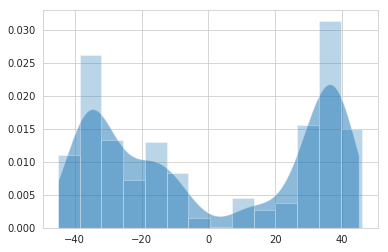

In [20]:
dens = sm.nonparametric.KDEUnivariate(data)
dens.fit()

kde_sm = dens.evaluate(x)
plt.fill_between(x, kde_sm, alpha=.5, label='KDE')
plt.hist(data, bins='auto', alpha=.3, density=True)

# Astronomy

In [21]:
cite1 = Citable("brightstars_declination.json", formats="local", project="computationalastronomy")
cite2 = Citable("brightstars1,6_declination.json", formats="local", project="computationalastronomy")

In [22]:
df_stars = cite2.digitalresource()
df_stars

,Achernar,Aldebaran,Rigel,Capella,Betelgeuse,Canopus,Sirius,Adara,Castor,Procyon,...,Regulus,Mimosa,Spica,Agena,Arcturus,Antares,Vega,Altair,Deneb,Fomalhaut
-4000,-57.169896,16.825185,-8.200734,46.710741,7.388852,-52.735266,-14.675475,-28.976037,32.135470,6.951050,...,11.959042,-59.667254,-11.108251,-60.331307,22.518107,-26.393278,38.304164,8.225213,45.277696,-29.348363
-4200,-57.167670,16.835702,-8.200703,46.734464,7.388249,-52.736581,-14.607544,-28.976164,32.143700,7.008512,...,11.958770,-59.666542,-11.106488,-60.329915,22.629156,-26.391989,38.288198,8.203799,45.277609,-29.339242
-4400,-57.165444,16.846220,-8.200672,46.758187,7.387646,-52.737895,-14.539613,-28.976292,32.151931,7.065974,...,11.958497,-59.665830,-11.104726,-60.328523,22.740204,-26.390700,38.272232,8.182386,45.277523,-29.330122
-4600,-57.163217,16.856737,-8.200640,46.781910,7.387043,-52.739210,-14.471682,-28.976419,32.160161,7.123435,...,11.958224,-59.665118,-11.102964,-60.327131,22.851253,-26.389411,38.256266,8.160973,45.277437,-29.321001
-4800,-57.160991,16.867254,-8.200609,46.805633,7.386440,-52.740525,-14.403751,-28.976546,32.168391,7.180897,...,11.957952,-59.664406,-11.101202,-60.325740,22.962302,-26.388122,38.240301,8.139560,45.277351,-29.311880
-5000,-57.158765,16.877771,-8.200578,46.829357,7.385836,-52.741839,-14.335820,-28.976673,32.176621,7.238359,...,11.957679,-59.663694,-11.099439,-60.324348,23.073350,-26.386832,38.224335,8.118146,45.277265,-29.302759


### Combine statistics with astronomy

In [23]:
def Combine(year=-4000):
    xcoords=list()
    labels=list()
    for element in df_stars.keys():
        xcoords.append(df_stars[element][year])
        labels.append(element)
    n_gates=5
    gmm = GaussianMixture(n_gates,covariance_type='spherical')
    gmm.fit(data)
    x = np.linspace(-45, 45, 3 * 2500 + 1)
    plt.figure(figsize=(32,10))
    plt.hist(data, bins='auto', alpha=.3, density=True, log=False)

    for i in np.arange(n_gates):
        mu=gmm.means_[i,0]
        var=gmm.covariances_[i]
        print("value: ", mu,"var",var)
        plt.vlines(mu, ymin=0, ymax=0.05, label='Fitted Means')
        plt.plot(x, norm.pdf(x, mu, np.sqrt(var)))
        plt.legend()
        plt.title('Gaussian Mixture Model')
    for xc,c in zip(xcoords,labels):
        plt.axvline(x=xc, label='line at x = {}'.format(n), c='r')
    plt.xticks(xcoords, labels, rotation='vertical')
    return plt.show()

value:  -11.814906024246342 var 19.54198836646464
value:  35.83570385971096 var 20.77257993117394
value:  -35.296088761386585 var 15.91490743321913
value:  15.79183326609144 var 33.07376934138111
value:  -20.180702720500122 var 24.391871469622462


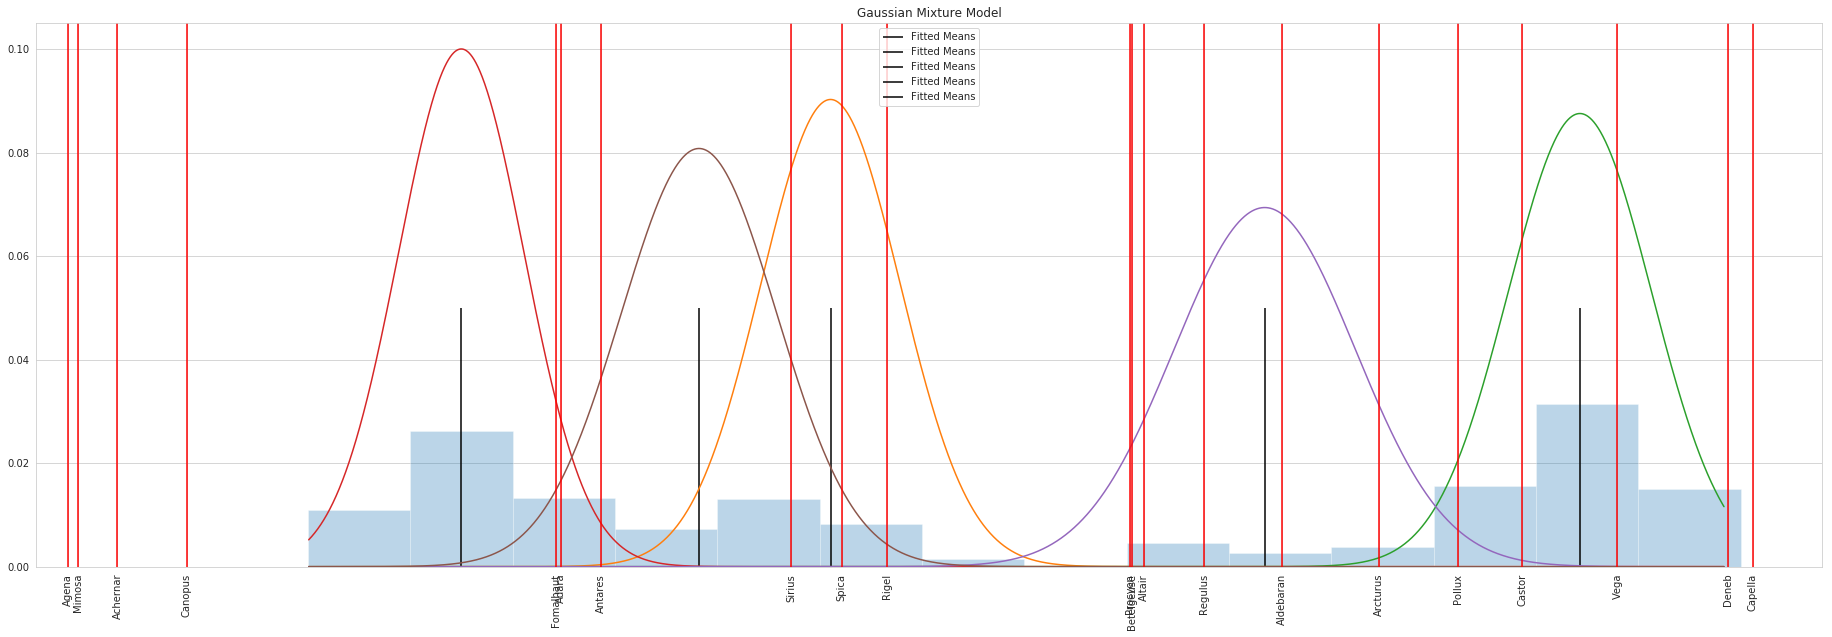

In [24]:
Combine(year=-5000)

# Show all Sites

In [25]:
sites = Citable("sites.json", formats="local", project="kreisgrabenanlage")
df=sites.digitalresource()
df.head()

,object,coordinates,altitude_asl,diameter,inner_diameter,outer_diameter,number_ditches,number_palisades,entrance_numbers,entrance_type,...,resources,outlet_numbers,outlet_type,outlet_orientation,outlet_info,outlet _numbers,outlet _type,outlet _orientation,StÃ€uble,altitude_masl
0,Quedlinburg I,"{'latitude': 51.8138447, 'longitude': 11.1772177}",124,,Distance from northwest gate to southeast gate...,About 98 meters at the largest width of the ou...,Two trenches and an irregular third ditch with...,Not obvious from geomagnetics; two rows of pal...,4.0,Lochenice-Unternberg,...,"{'overview': 'KGAL0001', 'plots': 'KGAL0002', ...",None,None,None,None,NaN,None,None,None,NaN
1,Quedlinburg II,"{'latitude': 51.81162, 'longitude': 11.108083}",126,no entry,no entry,around 60-62 meters at the largest width of th...,"Two circular ditches and a third, irregular, p...",Three concentric rings of palisades,NaN,None,...,"{'overview': 'KGAL0005', 'plots': 'KGAL0006', ...","3, possibly 4",Kothingeichendorf-TÄÅ¡etice,"Ditch outlets to the northwest, northeast and ...",Northe postulated another outlet to the southe...,NaN,None,None,None,NaN
2,Bielen,"{'latitude': 51.482888, 'longitude': 10.865373}",172,48 m,no entry,no entry,"one simple, circular trench",three concentric palisade rings with occasiona...,NaN,None,...,"{'overview': 'KGAL0009', 'plots': 'KGAL0010', ...",3,BuÄany-Svodin,"outlets to the southeast, south and west","each outlet with smaller, centrally-placed tre...",NaN,None,None,None,NaN
3,Bochow,"{'latitude': 51.962024, 'longitude': 13.083037}",80,60-80 m,no entry,no entry,double circular enclosure with v-shaped ditche...,"three concentric palisade ditches, one poorly ...",NaN,None,...,"{'overview': 'KGAL0013', 'plots': 'KGAL0014', ...",5,"mixed: Literski in NW, others Kothingeichendor...","at least one outlet in the northwest, ditch in...",no entry,NaN,None,None,None,NaN
4,Goseck,"{'latitude': 51.198242, 'longitude': 11.86464}",160,71-75 m,no entry,no entry,"one simple, nearly circular ditch with a v-sha...",two concentric palisade trenches with a distan...,NaN,None,...,"{'overview': 'KGAL0017', 'plots': 'KGAL0018', ...",None,BuÄany-Svodin,"outlets to the north, southeast and southwest",other interruptions in the palisade trenches (...,3.0,None,None,None,NaN


### creat sub-dataframe

In [26]:
sites = df[["object","resources"]]
sites.head()

,object,resources
0,Quedlinburg I,"{'overview': 'KGAL0001', 'plots': 'KGAL0002', ..."
1,Quedlinburg II,"{'overview': 'KGAL0005', 'plots': 'KGAL0006', ..."
2,Bielen,"{'overview': 'KGAL0009', 'plots': 'KGAL0010', ..."
3,Bochow,"{'overview': 'KGAL0013', 'plots': 'KGAL0014', ..."
4,Goseck,"{'overview': 'KGAL0017', 'plots': 'KGAL0018', ..."


In [27]:
def ShowSites(site="", types="plots"):
    obj= sites["resources"][(sites["object"] == site)][0]
    d=Citable(obj[types], formats="et")
    return d.imageshow(())

In [28]:
ShowSites(site="Quedlinburg I", types="plots")